In [1]:
import config
from config import *
%matplotlib inline

#removed element ratios

2022-02-14 19:39:39.448992: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
        
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx]),
            np.unique(x.region_vals[idx], return_counts=True)[1][1] # returns the number of true (1's) values in the identified region
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [3]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X1=x.features
X1.shape

(110, 14)

In [4]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
           
X_Cu2=x.Patches_Cu
X_Zn2=x.Patches_Zn
X_Ca2=x.Patches_Ca
X_K2=x.Patches_K
X_P2=x.Patches_P
X_S2=x.Patches_S
X_Fe2=x.Patches_Fe
X_Ni2=x.Patches_Ni
X_TFY2=x.Patches_TFY

X2=x.features
X2.shape

(41, 14)

In [5]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img

X_Cu3=x.Patches_Cu
X_Zn3=x.Patches_Zn
X_Ca3=x.Patches_Ca
X_K3=x.Patches_K
X_P3=x.Patches_P
X_S3=x.Patches_S
X_Fe3=x.Patches_Fe
X_Ni3=x.Patches_Ni
X_TFY3=x.Patches_TFY

X3=x.features
X3.shape

(43, 14)

In [6]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img

X_Cu4=x.Patches_Cu
X_Zn4=x.Patches_Zn
X_Ca4=x.Patches_Ca
X_K4=x.Patches_K
X_P4=x.Patches_P
X_S4=x.Patches_S
X_Fe4=x.Patches_Fe
X_Ni4=x.Patches_Ni
X_TFY4=x.Patches_TFY

X4=x.features
X4.shape

(53, 14)

In [7]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()

X_bin5=x.binary_img

X_Cu5=x.Patches_Cu
X_Zn5=x.Patches_Zn
X_Ca5=x.Patches_Ca
X_K5=x.Patches_K
X_P5=x.Patches_P
X_S5=x.Patches_S
X_Fe5=x.Patches_Fe
X_Ni5=x.Patches_Ni
X_TFY5=x.Patches_TFY


X5=x.features
X5.shape

(55, 14)

In [8]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img

X_Cu6=x.Patches_Cu
X_Zn6=x.Patches_Zn
X_Ca6=x.Patches_Ca
X_K6=x.Patches_K
X_P6=x.Patches_P
X_S6=x.Patches_S
X_Fe6=x.Patches_Fe
X_Ni6=x.Patches_Ni
X_TFY6=x.Patches_TFY


X6=x.features
X6.shape

(39, 14)

In [9]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img

X_Cu7=x.Patches_Cu
X_Zn7=x.Patches_Zn
X_Ca7=x.Patches_Ca
X_K7=x.Patches_K
X_P7=x.Patches_P
X_S7=x.Patches_S
X_Fe7=x.Patches_Fe
X_Ni7=x.Patches_Ni
X_TFY7=x.Patches_TFY

X7=x.features
X7.shape

(57, 14)

In [10]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img


X_Cu8=x.Patches_Cu
X_Zn8=x.Patches_Zn
X_Ca8=x.Patches_Ca
X_K8=x.Patches_K
X_P8=x.Patches_P
X_S8=x.Patches_S
X_Fe8=x.Patches_Fe
X_Ni8=x.Patches_Ni
X_TFY8=x.Patches_TFY

X8=x.features
X8.shape

(61, 14)

In [11]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img

X_Cu9=x.Patches_Cu
X_Zn9=x.Patches_Zn
X_Ca9=x.Patches_Ca
X_K9=x.Patches_K
X_P9=x.Patches_P
X_S9=x.Patches_S
X_Fe9=x.Patches_Fe
X_Ni9=x.Patches_Ni
X_TFY9=x.Patches_TFY

X9=x.features
X9.shape

(31, 14)

In [12]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img

X_Cu10=x.Patches_Cu
X_Zn10=x.Patches_Zn
X_Ca10=x.Patches_Ca
X_K10=x.Patches_K
X_P10=x.Patches_P
X_S10=x.Patches_S
X_Fe10=x.Patches_Fe
X_Ni10=x.Patches_Ni
X_TFY10=x.Patches_TFY


X10=x.features
X10.shape

(64, 14)

In [13]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))
X_Cu=np.concatenate((X_Cu1,X_Cu2,X_Cu3,X_Cu4,X_Cu5,X_Cu6,X_Cu7,X_Cu8,X_Cu9,X_Cu10))
X_Zn=np.concatenate((X_Zn1,X_Zn2,X_Zn3,X_Zn4,X_Zn5,X_Zn6,X_Zn7,X_Zn8,X_Zn9,X_Zn10))
X_Ca=np.concatenate((X_Ca1,X_Ca2,X_Ca3,X_Ca4,X_Ca5,X_Ca6,X_Ca7,X_Ca8,X_Ca9,X_Ca10))
X_K=np.concatenate((X_K1,X_K2,X_K3,X_K4,X_K5,X_K6,X_K7,X_K8,X_K9,X_K10))
X_P=np.concatenate((X_P1,X_P2,X_P3,X_P4,X_P5,X_P6,X_P7,X_P8,X_P9,X_P10))
X_S=np.concatenate((X_S1,X_S2,X_S3,X_S4,X_S5,X_S6,X_S7,X_S8,X_S9,X_S10))
X_Fe=np.concatenate((X_Fe1,X_Fe2,X_Fe3,X_Fe4,X_Fe5,X_Fe6,X_Fe7,X_Fe8,X_Fe9,X_Fe10))
X_Ni=np.concatenate((X_Ni1,X_Ni2,X_Ni3,X_Ni4,X_Ni5,X_Ni6,X_Ni7,X_Ni8,X_Ni9,X_Ni10))
X_TFY=np.concatenate((X_TFY1,X_TFY2,X_TFY3,X_TFY4,X_TFY5,X_TFY6,X_TFY7,X_TFY8,X_TFY9,X_TFY10))


In [14]:
print(X.shape)
print(X_bin.shape)

(554, 14)
(554, 32, 32)


In [36]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

def viewer(idx):

    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    im1 = ax1.imshow(X_bin[idx].T, interpolation='none')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', vmax=0.003087)
#     im2 = ax2.imshow(X_Cu[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    im3 = ax3.imshow(X_Zn[idx].T, interpolation='none', vmax=0.00318)
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    im4 = ax4.imshow(X_Ca[idx].T, interpolation='none', vmax=0.00174)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    im5 = ax5.imshow(X_K[idx].T, interpolation='none',vmax=0.000584)
#     im5 = ax5.imshow(X_K[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    im6 = ax6.imshow(X_P[idx].T, interpolation='none', vmax=0.000164)
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    im7 = ax7.imshow(X_S[idx].T, interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    im8 = ax8.imshow(X_Ni[idx].T, interpolation='none', vmax=0.000093)
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    im9 = ax9.imshow(X_Fe[idx].T, interpolation='none', vmax=0.000139)
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    im10 = ax10.imshow(X_TFY[idx].T, interpolation='none', vmax=0.029495)
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');


interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [16]:
#create the dataframe

principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])

principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]
principalDf['Pixel_count'] = X[:,13].astype(int)

In [17]:
principalDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY
0,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000029,0.001002,0.000071,0.001002,0.015246
1,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000043,0.000768,0.000062,0.000768,0.015790
2,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.000045,0.000043,0.001093,0.000095,0.001093,0.018312
3,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610
4,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,25,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,0.000059,0.000095,0.000059,0.005291
550,66,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,0.000099,0.000125,0.000099,0.005216
551,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,0.000064,0.000068,0.000064,0.004908
552,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,0.000101,0.000029,0.000031,0.000116,0.000031,0.004815


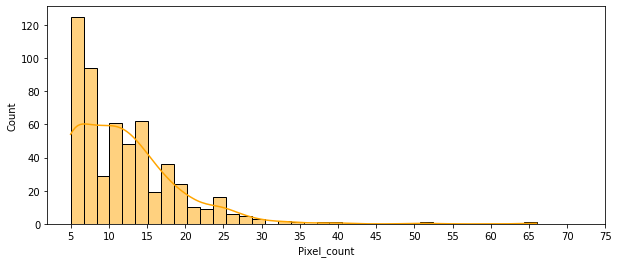

In [31]:
fig = plt.figure(figsize=(10, 4))
ss_plot=sns.histplot(data=principalDf, x="Pixel_count", kde=True,color='orange')
plt.xticks([5,10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60,65,70,75]);


In [50]:


# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(principalDf[principalDf['Pixel_count']==10])
principalDf[principalDf['Pixel_count']==8]

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY
12,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000053,0.000076,0.000031,0.001102,0.000074,0.001102,0.017285
19,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000058,0.000060,0.000065,0.001461,0.000073,0.001461,0.019889
23,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000015,0.000052,0.000059,0.000957,0.000074,0.000957,0.018570
28,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000077,0.000073,0.000057,0.001496,0.000059,0.001496,0.015950
36,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000044,0.000111,0.000044,0.001564,0.000077,0.001564,0.017658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000289,0.000104,0.000078,0.000061,0.000132,0.000061,0.004789
534,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000478,0.000090,0.000062,0.000071,0.000062,0.000071,0.005697
538,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000811,0.000094,0.000031,0.000054,0.000108,0.000054,0.004864
539,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000424,0.000064,0.000062,0.000089,0.000065,0.000089,0.005132


In [51]:
secondaryDf=principalDf

In [52]:
#filter out the outliers/artifacts

#create dataframe with artifacts and outliers removed

# secondaryDf.drop(secondaryDf[secondaryDf['major_axis_length'] == secondaryDf['minor_axis_length']].index, inplace = True)
secondaryDf.drop(secondaryDf[secondaryDf['Pixel_count'] <=8 ].index, inplace = True)


In [53]:
secondaryDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY
3,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610
4,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674
6,23,1.4375,0.579046,1.352879,1.519026,1.238454,3.974874,0.000041,0.000040,0.000043,0.001565,0.000070,0.001565,0.016977
9,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000044,0.000061,0.000061,0.001335,0.000071,0.001335,0.018209
11,28,1.7500,0.484511,1.492705,1.638394,1.433243,4.474874,0.000041,0.000043,0.000068,0.001369,0.000098,0.001369,0.015505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,17,1.0625,0.919900,1.163107,1.868381,0.732690,3.474874,0.000347,0.000164,0.000034,0.000088,0.000116,0.000088,0.005032
549,25,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,0.000059,0.000095,0.000059,0.005291
550,66,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,0.000099,0.000125,0.000099,0.005216
551,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,0.000064,0.000068,0.000064,0.004908


In [54]:
secondaryDf.index.to_numpy()

array([  3,   4,   6,   9,  11,  12,  13,  14,  15,  17,  18,  19,  20,
        21,  23,  25,  26,  27,  28,  32,  36,  38,  39,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  53,  54,  56,  58,  59,  60,
        61,  64,  65,  66,  69,  70,  72,  76,  78,  80,  81,  82,  85,
        86,  87,  89,  90,  93,  98,  99, 102, 105, 106, 107, 112, 114,
       115, 116, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132,
       135, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 151, 153,
       155, 159, 160, 161, 162, 165, 169, 171, 173, 175, 178, 179, 180,
       182, 183, 186, 187, 190, 191, 193, 196, 197, 198, 201, 204, 205,
       206, 207, 208, 209, 210, 211, 213, 214, 215, 217, 219, 221, 222,
       223, 224, 225, 227, 229, 230, 231, 232, 233, 234, 235, 236, 238,
       239, 242, 243, 244, 248, 254, 256, 257, 260, 261, 262, 264, 265,
       266, 267, 269, 270, 275, 276, 277, 278, 279, 281, 283, 285, 286,
       288, 289, 290, 291, 292, 293, 294, 295, 298, 300, 305, 30

In [55]:
# make sure you can view every channel and the binary image here

In [56]:
mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ni'],secondaryDf['Zn'],secondaryDf['Fe'],
    secondaryDf['Cu'],secondaryDf['BFY']
               ]).T

In [57]:
mod_X.shape

(335, 13)

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(mod_X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)


# reduced_X = PCA(=2).fit(X)

In [59]:
principalComponents.shape

(335, 2)

In [60]:
print(X_standard[0])

secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]




print(pca.singular_values_)
print(pca.explained_variance_)
print(pca.components_)

[ 0.81219558  0.30825891  0.95146196  0.41982729  0.73741671  0.72215698
 -0.55134043  0.6034349   0.65122845  0.59927113 -0.4931429   0.59927113
  0.7060931 ]
[40.08490946 34.60518214]
[4.81077834 3.58538512]
[[ 0.40910809  0.15992405  0.40678559  0.39251806  0.26075407  0.39034479
   0.22702111  0.25526457  0.18643671 -0.09507416  0.25258936 -0.09507416
  -0.1838787 ]
 [ 0.21274518  0.00740609  0.21670695  0.13712945  0.21853368  0.21477179
  -0.4129246  -0.26025895 -0.0230579   0.41430644 -0.2047357   0.41430644
   0.41357573]]


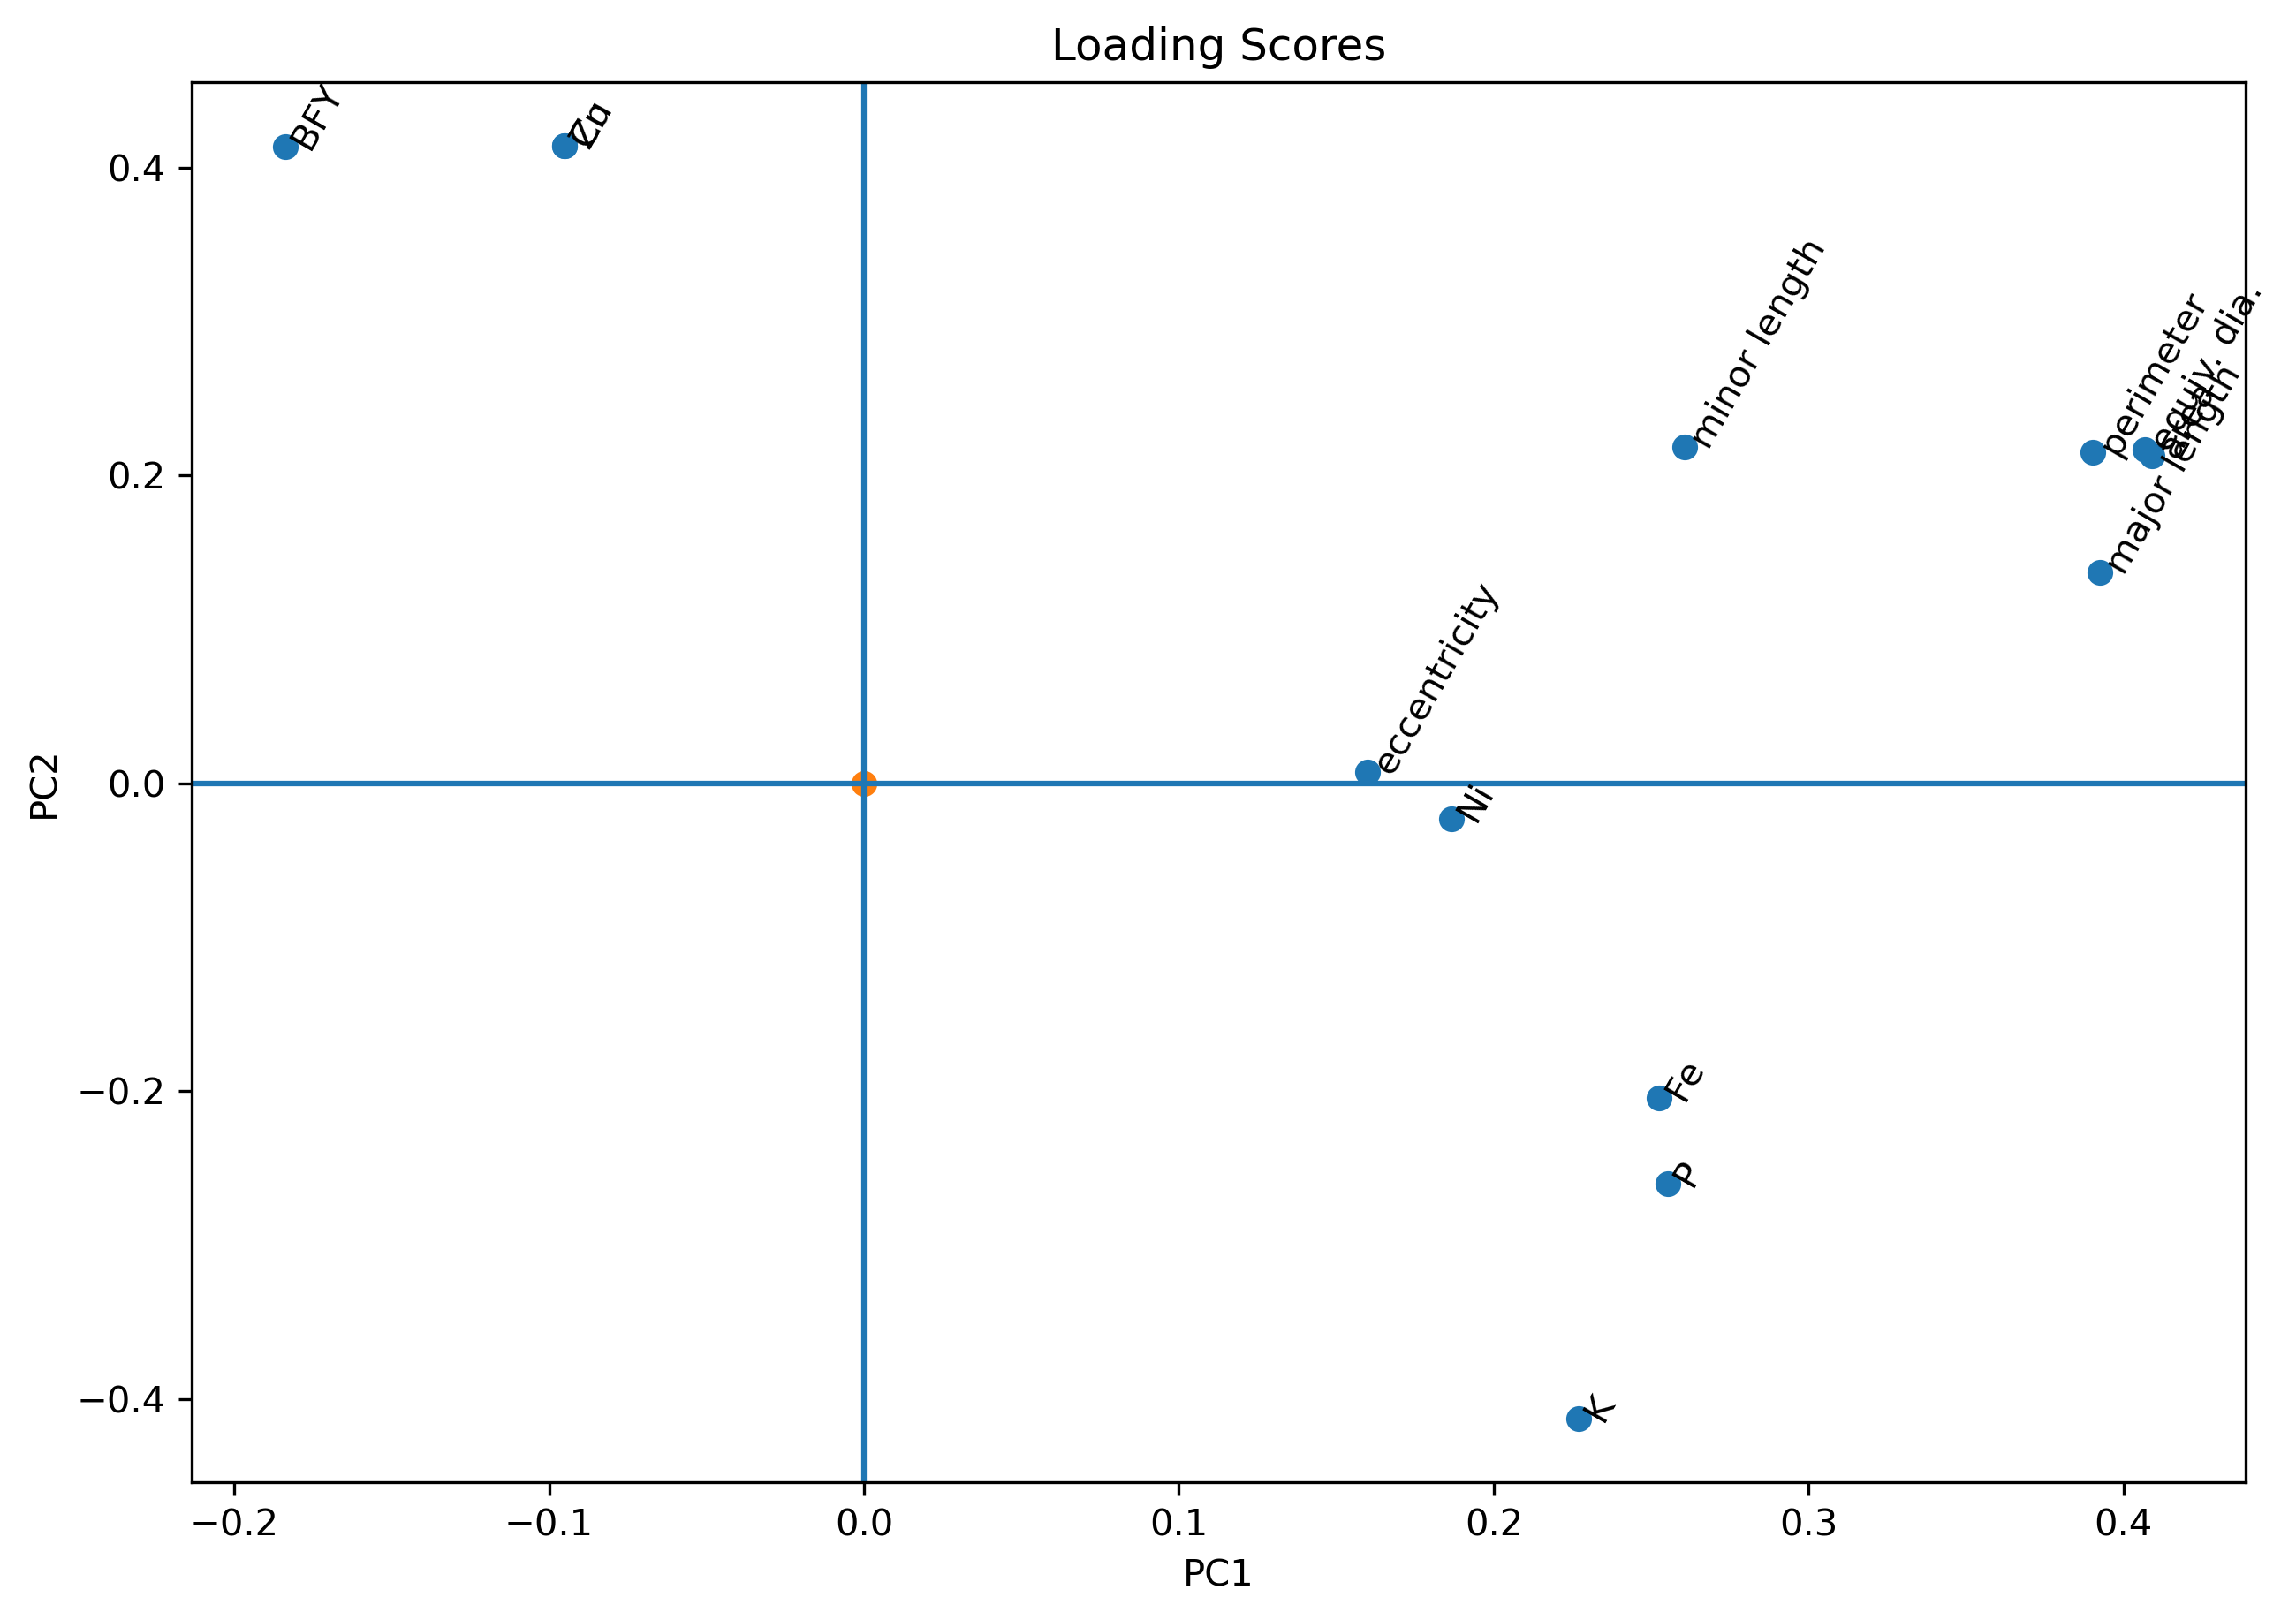

In [61]:
fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()


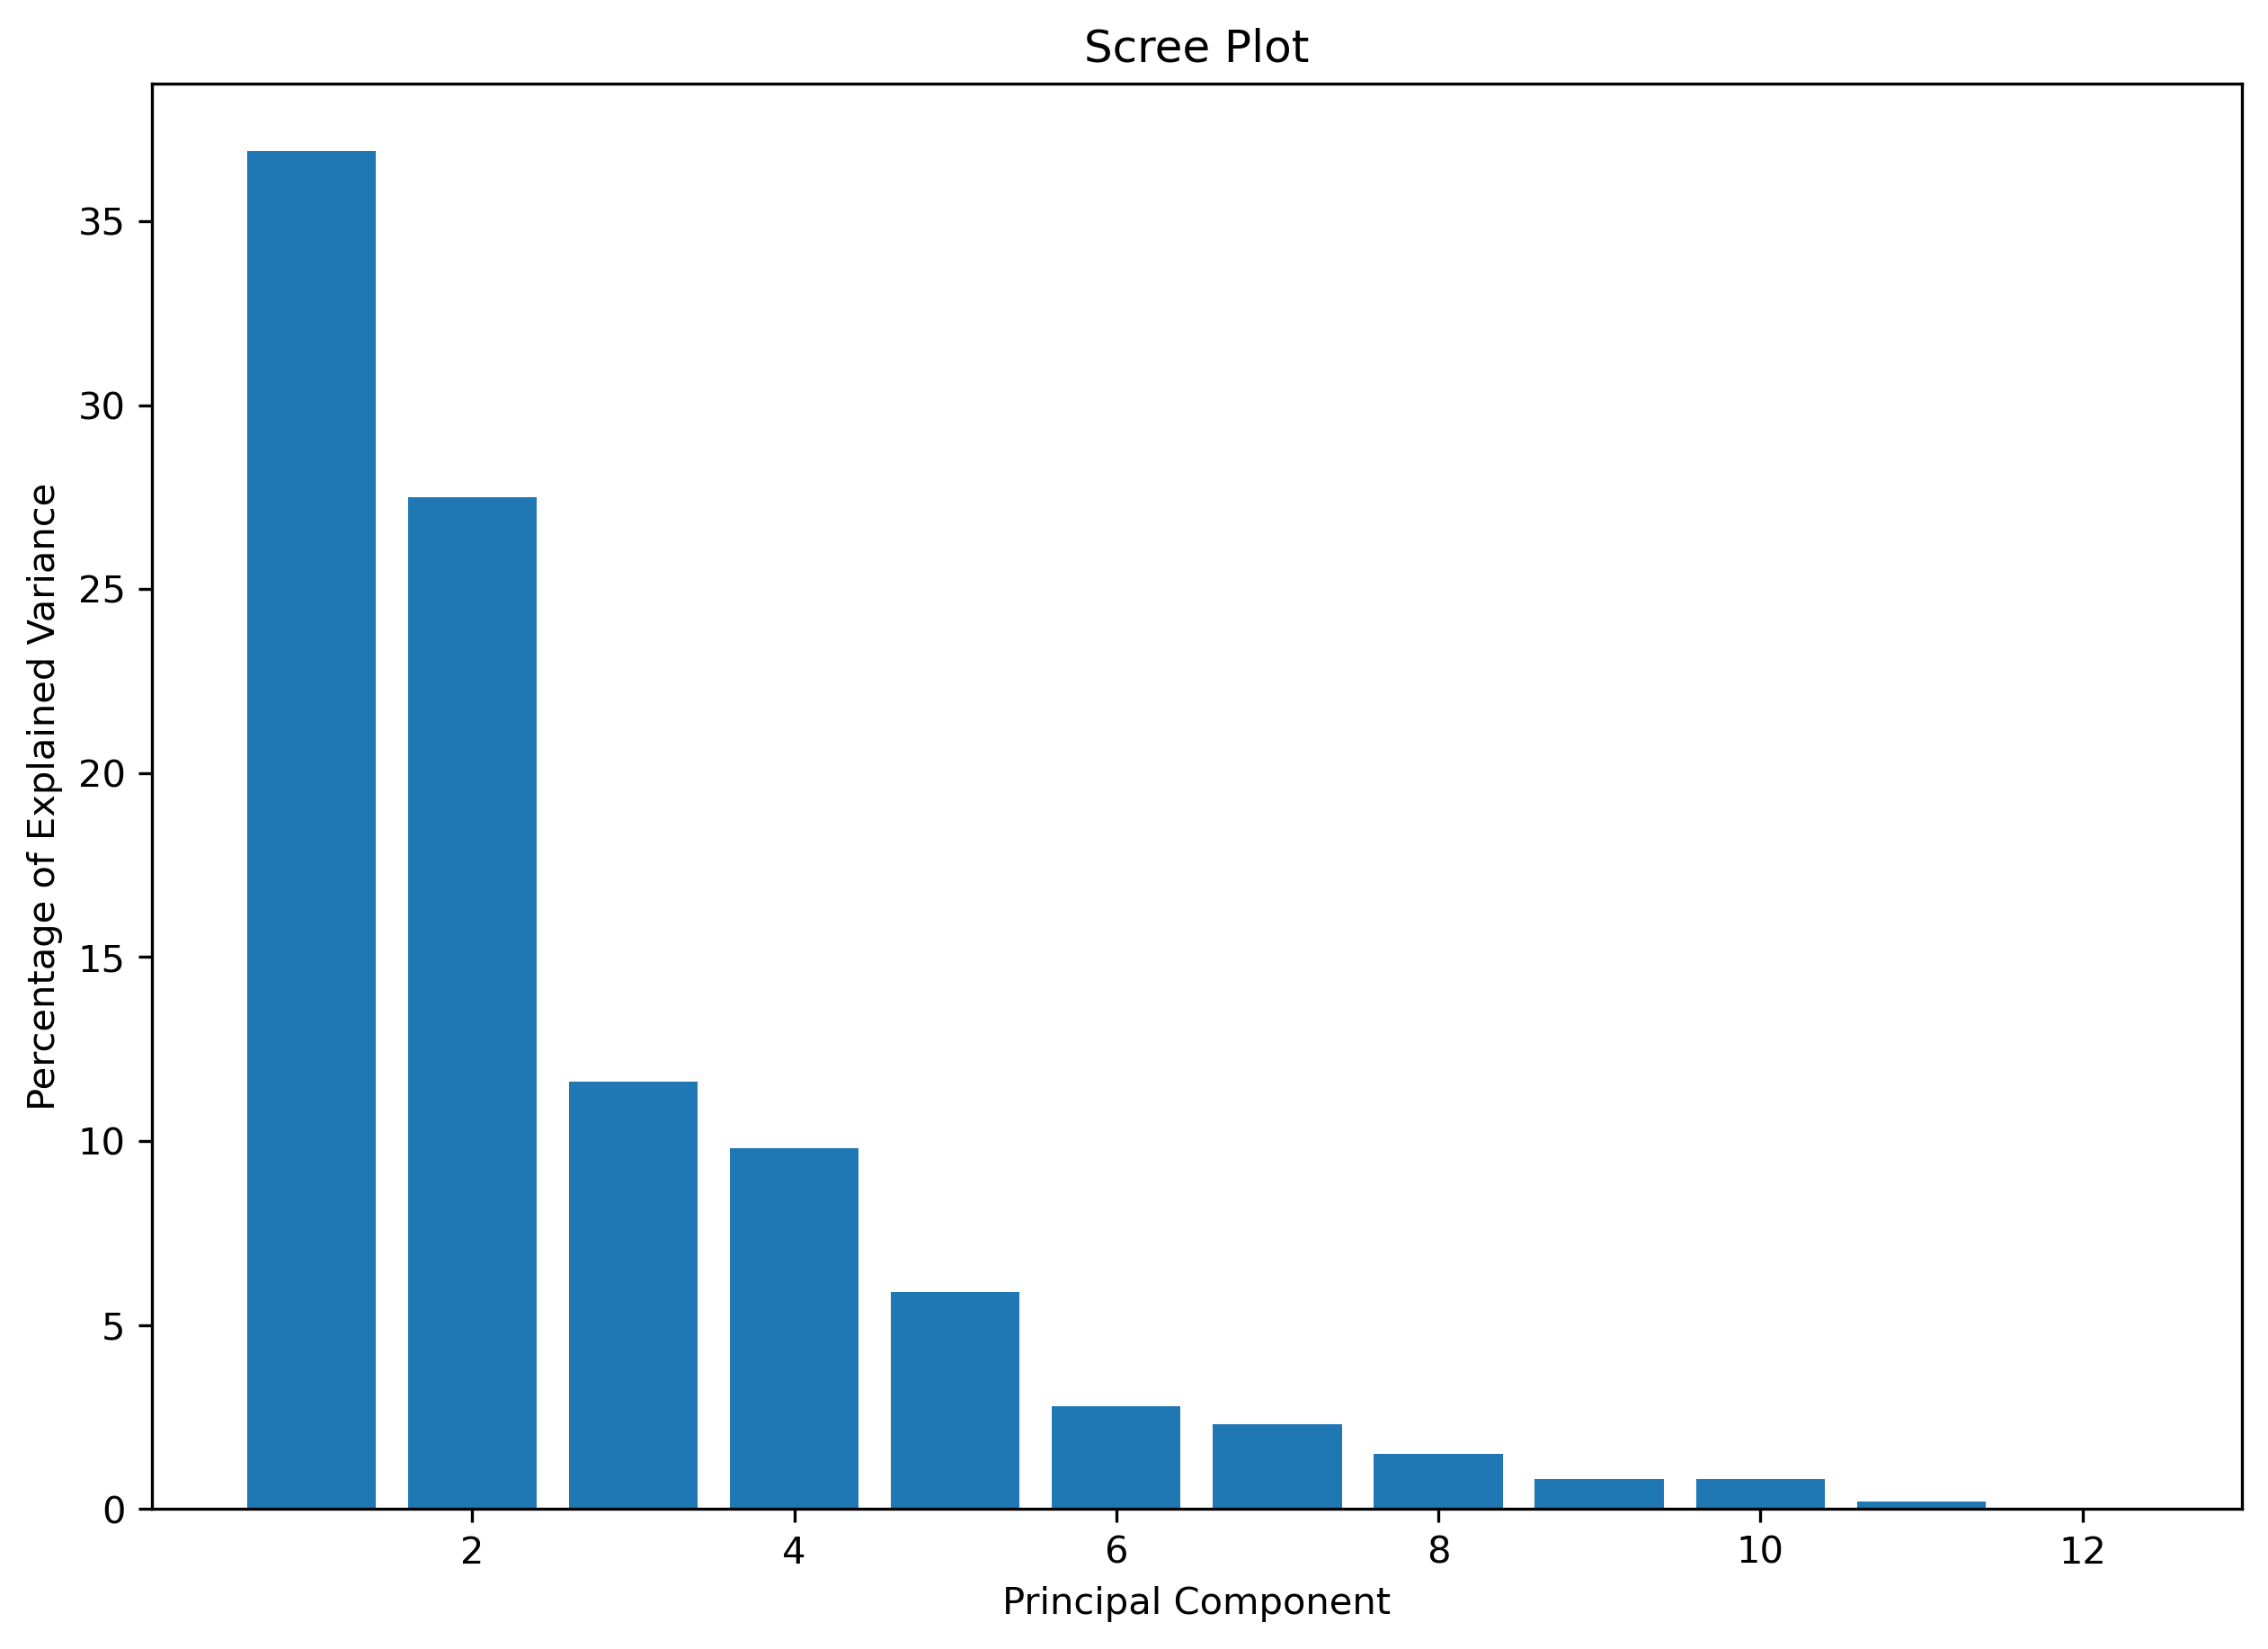

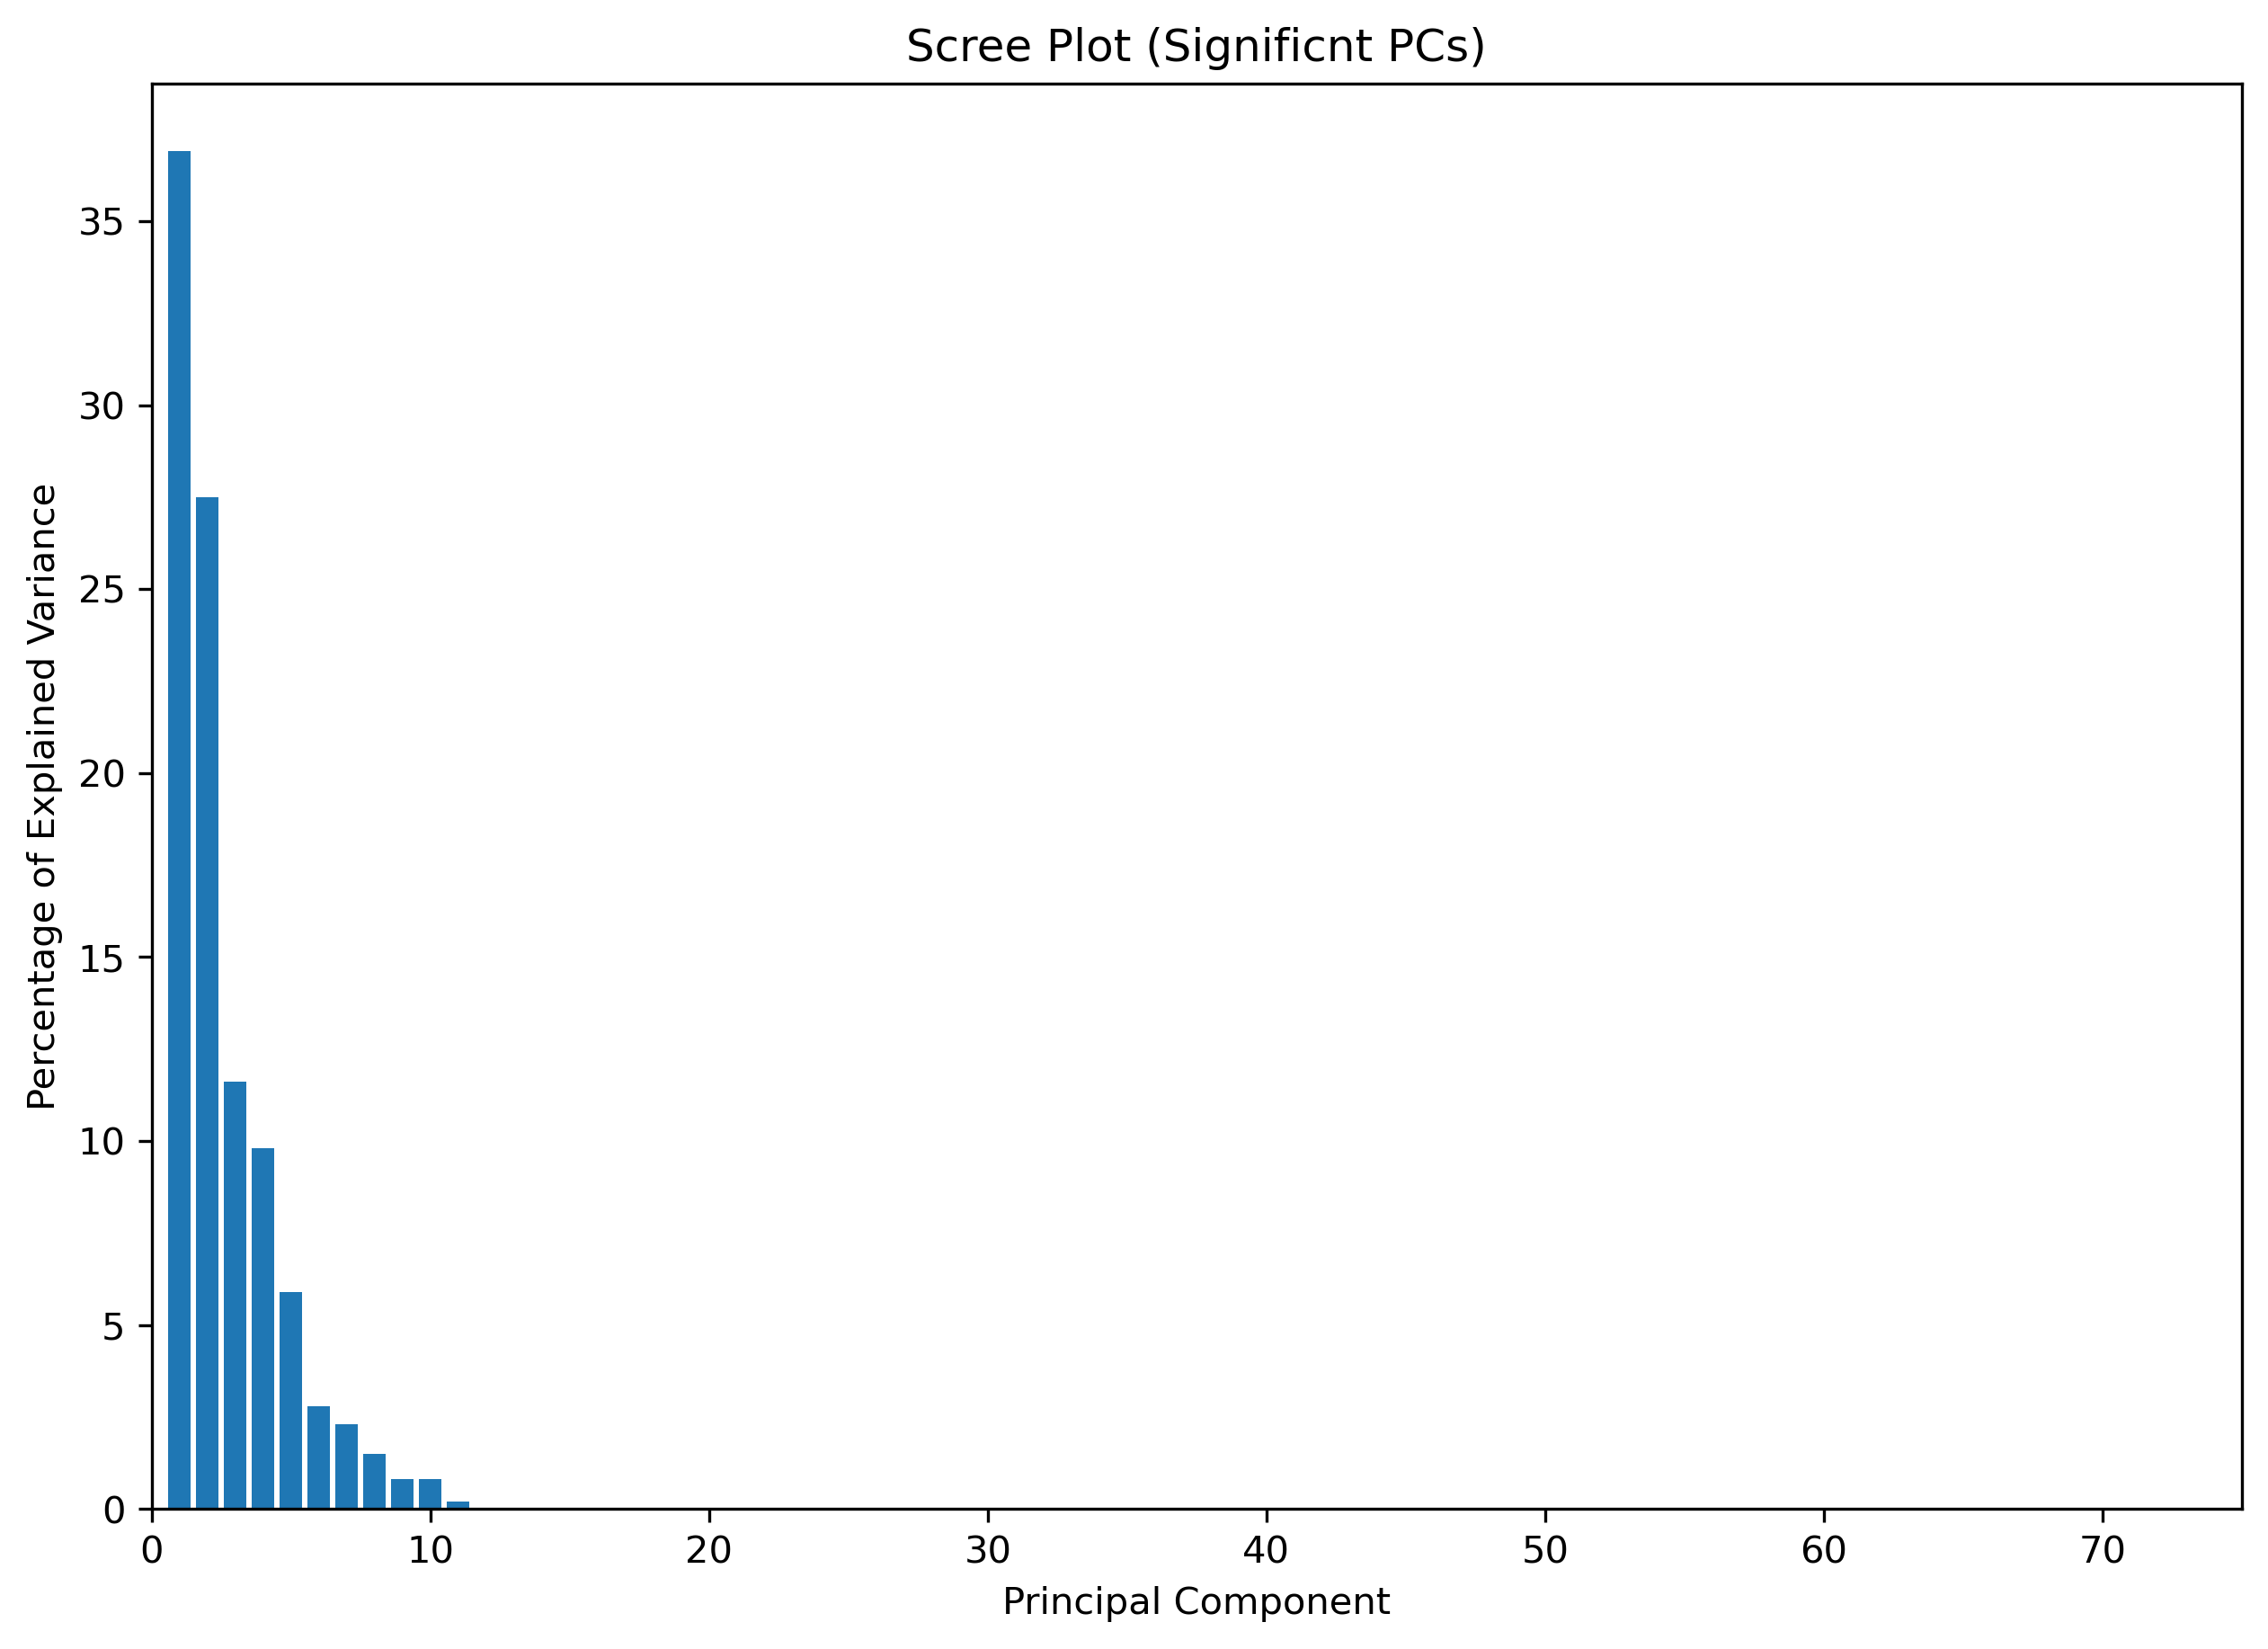

In [62]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [63]:
# principalDf['area'] = X[:,0]
# principalDf['eccentricity'] = X[:,1]
# principalDf['equivalent_diameter'] = X[:,2]
# principalDf['major_axis_length'] = X[:,3]
# principalDf['minor_axis_length'] = X[:,4]
# principalDf['perimeter'] = X[:,5]
# principalDf['K'] = X[:,6]
# principalDf['P'] = X[:,7]
# principalDf['Ni'] = X[:,8]
# principalDf['Zn'] = X[:,9]
# principalDf['Fe'] = X[:,10]
# principalDf['Cu'] = X[:,11]
# principalDf['BFY'] = X[:,12]

In [64]:
print(secondaryDf['area'].max())
print(secondaryDf['eccentricity'].max())
print(secondaryDf['equivalent_diameter'].max())
print(secondaryDf['major_axis_length'].max())
print(secondaryDf['minor_axis_length'].max())
print(secondaryDf['perimeter'] .max())
print(secondaryDf['K'].max())
print(secondaryDf['P'].max()) 
print(secondaryDf['Ni'].max()) 
print(secondaryDf['Zn'].max()) 
print(secondaryDf['Fe'].max()) 
print(secondaryDf['Cu'].max()) 
print(secondaryDf['BFY'].max()) 

4.125
0.9769395940802652
2.2917489221187703
4.373612352851659
2.4812696957111178
10.321067811865476
0.0008107276516966522
0.00019250296463724226
0.00010869805555557832
0.007895824499428272
0.000182758885785006
0.007895824499428272
0.025465836748480797


In [65]:
print(secondaryDf['area'].median())
print(secondaryDf['eccentricity'].median())
print(secondaryDf['equivalent_diameter'].median())
print(secondaryDf['major_axis_length'].median())
print(secondaryDf['minor_axis_length'].median())
print(secondaryDf['perimeter'] .median())
print(secondaryDf['K'].median())
print(secondaryDf['P'].median()) 
print(secondaryDf['Ni'].median()) 
print(secondaryDf['Zn'].median()) 
print(secondaryDf['Fe'].median()) 
print(secondaryDf['Cu'].median()) 
print(secondaryDf['BFY'].median()) 

0.875
0.829925002758732
1.055502061411188
1.4142135623730951
0.7788798979701944
2.9748737341529163
4.438357427716255e-05
4.716495095635764e-05
4.274914681445807e-05
0.001014451147057116
6.483930337708443e-05
0.001014451147057116
0.01485363394021988


In [66]:
secondaryDf['original index'] = secondaryDf.index.to_numpy()

In [67]:
secondaryDf.reset_index(drop=True, inplace=True)

In [68]:
secondaryDf

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index
0,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610,1.189513,1.700230,3
1,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674,-0.123614,0.700603,4
2,23,1.4375,0.579046,1.352879,1.519026,1.238454,3.974874,0.000041,0.000040,0.000043,0.001565,0.000070,0.001565,0.016977,1.081294,2.665376,6
3,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000044,0.000061,0.000061,0.001335,0.000071,0.001335,0.018209,-0.693361,0.877245,9
4,28,1.7500,0.484511,1.492705,1.638394,1.433243,4.474874,0.000041,0.000043,0.000068,0.001369,0.000098,0.001369,0.015505,2.893935,2.752832,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,17,1.0625,0.919900,1.163107,1.868381,0.732690,3.474874,0.000347,0.000164,0.000034,0.000088,0.000116,0.000088,0.005032,2.415349,-3.133381,547
331,25,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,0.000059,0.000095,0.000059,0.005291,4.626116,-1.733450,549
332,66,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,0.000099,0.000125,0.000099,0.005216,15.481648,3.973830,550
333,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,0.000064,0.000068,0.000064,0.004908,-0.324431,-3.536501,551


<AxesSubplot:xlabel='Pixel_count', ylabel='Count'>

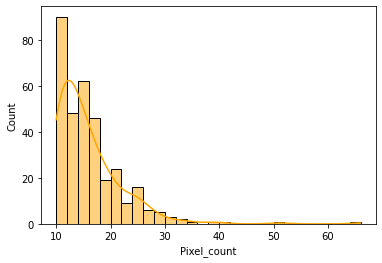

In [69]:
sns.histplot(data=secondaryDf, x="Pixel_count", kde=True,color='orange')



<AxesSubplot:xlabel='eccentricity', ylabel='Count'>

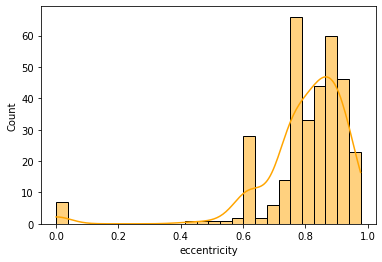

In [70]:
sns.histplot(data=secondaryDf, x="eccentricity", kde=True,color='orange')



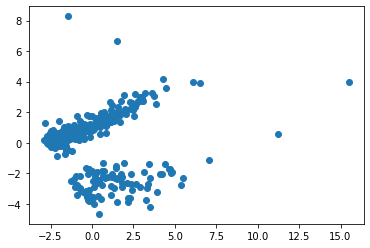

In [71]:
plt.scatter(secondaryDf['PC1'],secondaryDf['PC2'])

In [72]:
# Custom condition to view cells
True_list = secondaryDf.loc[
    (secondaryDf['eccentricity'] > 0) &
    (secondaryDf['eccentricity'] <= 0.7)
    
   ].index.tolist()
print( len(True_list) )

38


In [73]:
True_list

[2,
 4,
 8,
 10,
 19,
 24,
 31,
 58,
 68,
 74,
 76,
 77,
 88,
 97,
 99,
 100,
 107,
 112,
 141,
 147,
 148,
 156,
 158,
 162,
 172,
 180,
 195,
 221,
 222,
 229,
 254,
 260,
 268,
 277,
 278,
 281,
 292,
 301]

In [78]:
(secondaryDf['K']/secondaryDf['P']).median()

1.1327179039399027

In [89]:

# now create mult label data frame with strict conditions

labels = [0] * mod_X.shape[0]


secondaryDf['text_labels'] = labels


# (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]=1
    
# (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['Ni']>=0.25*secondaryDf['Ni'].median()) &
    (secondaryDf['Ni']/secondaryDf['P']>= 0.25*(secondaryDf['Ni']/secondaryDf['P']).median()) &
    (secondaryDf['Ni']/secondaryDf['Zn']>= 0.25*(secondaryDf['Ni']/secondaryDf['Zn']).median()) &
    (secondaryDf['Ni']/secondaryDf['Fe']>= 0.25*(secondaryDf['Ni']/secondaryDf['Fe']).median()) &
    (secondaryDf['Ni']/secondaryDf['K']>= 0.25*(secondaryDf['Ni']/secondaryDf['K']).median()) &
    (secondaryDf['Cu']/secondaryDf['K']>= 0.25*(secondaryDf['Cu']/secondaryDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]=2 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'unassigned'
    if labels[idx] ==1:
        labels[idx] = 'live cells'
    if labels[idx] ==2:
        labels[idx] = 'dead cells'


        
        
secondaryDf['text_labels'] = labels


117
230


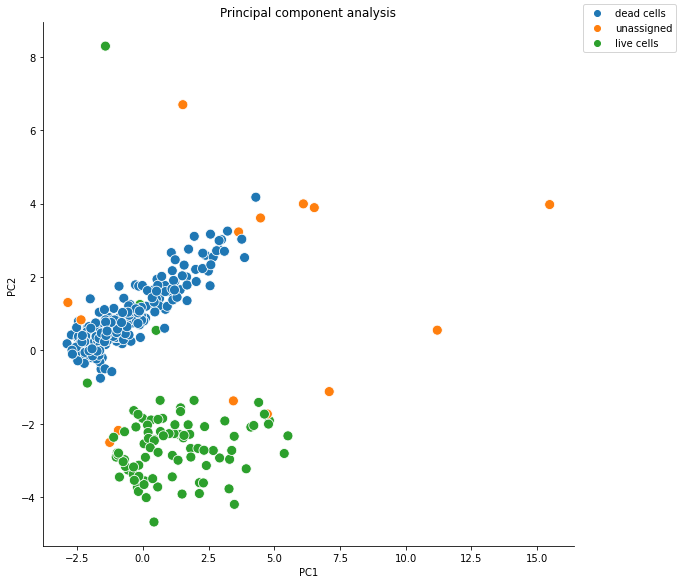

In [92]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [48]:
secondaryDf[secondaryDf['PC2'] >= 8]

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,Pixel_count,original index,text_labels
278,-1.424169,8.288896,1.1875,0.654066,1.229623,1.424686,1.077686,3.474874,0.000049,0.000029,0.000042,0.00714,0.000066,0.00714,0.016984,19,465,live cells


In [79]:
secondaryDf[secondaryDf['text_labels'] == 'unassigned']

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels
7,40,2.5000,0.801105,1.784124,2.508883,1.501627,6.328427,0.000049,0.000077,0.000075,0.001258,0.000101,0.001258,0.016144,6.524042,3.889858,14,unassigned
27,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000043,0.000173,0.000034,0.002329,0.000086,0.002329,0.016136,-1.736448,0.685013,45,unassigned
66,25,1.5625,0.976940,1.410474,3.151873,0.672975,2.621320,0.000320,0.000089,0.000060,0.000117,0.000096,0.000117,0.009100,3.445390,-1.372314,116,unassigned
87,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000281,0.000067,0.000085,0.000091,0.000063,0.000091,0.008952,-0.932550,-2.176123,147,unassigned
89,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000339,0.000078,0.000030,0.000059,0.000074,0.000059,0.008357,-1.260596,-2.504180,151,unassigned
128,30,1.8750,0.966921,1.545097,3.168776,0.808273,5.785534,0.000042,0.000055,0.000040,0.001380,0.000049,0.001380,0.016195,3.644294,3.227485,221,unassigned
135,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000034,0.000063,0.000036,0.001162,0.000053,0.001162,0.015732,-2.502553,0.419257,230,unassigned
157,12,0.7500,0.000000,0.977205,0.957427,0.957427,2.414214,0.000030,0.000036,0.000036,0.000676,0.000061,0.000676,0.015042,-2.464612,-0.042906,267,unassigned
170,19,1.1875,0.864794,1.229623,1.802124,0.904893,3.621320,0.000083,0.000175,0.000087,0.007896,0.000183,0.007896,0.014439,1.521820,6.694104,289,unassigned
186,38,2.3750,0.974075,1.738949,3.775956,0.854221,7.303301,0.000052,0.000078,0.000044,0.001539,0.000058,0.001539,0.014038,6.108402,3.992589,316,unassigned


In [76]:
interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [85]:


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,PC1,PC2,original index,text_labels,Class
0,21,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610,1.189513,1.700230,3,dead cells,1
1,17,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674,-0.123614,0.700603,4,dead cells,1
2,23,1.4375,0.579046,1.352879,1.519026,1.238454,3.974874,0.000041,0.000040,0.000043,0.001565,0.000070,0.001565,0.016977,1.081294,2.665376,6,dead cells,1
3,14,0.8750,0.829925,1.055502,1.414214,0.788954,2.974874,0.000044,0.000061,0.000061,0.001335,0.000071,0.001335,0.018209,-0.693361,0.877245,9,dead cells,1
4,28,1.7500,0.484511,1.492705,1.638394,1.433243,4.474874,0.000041,0.000043,0.000068,0.001369,0.000098,0.001369,0.015505,2.893935,2.752832,11,dead cells,1
5,11,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000053,0.000076,0.000031,0.001102,0.000074,0.001102,0.017285,-1.799487,-0.122205,12,dead cells,1
6,20,1.2500,0.923102,1.261566,2.055523,0.790460,3.621320,0.000059,0.000042,0.000044,0.001452,0.000056,0.001452,0.017487,0.539015,1.938832,13,dead cells,1
7,40,2.5000,0.801105,1.784124,2.508883,1.501627,6.328427,0.000049,0.000077,0.000075,0.001258,0.000101,0.001258,0.016144,6.524042,3.889858,14,unassigned,1
8,10,0.6250,0.616441,0.892062,1.000000,0.787401,2.267767,0.000034,0.000047,0.000045,0.001104,0.000061,0.001104,0.015610,-2.370056,0.005370,15,dead cells,1
9,12,0.7500,0.767579,0.977205,1.215187,0.778880,2.621320,0.000044,0.000068,0.000048,0.001030,0.000062,0.001030,0.018261,-1.486657,0.278669,17,dead cells,1


In [81]:
# calculate kmeans cluster centers
def _format_soft_km_axes(ax, **kwargs):
    
    """ 
    input: axes and key word arguments
    param: ax - axes to be formatted
    param: border - boolean, True = grey border, False = None. Default True
    """
    
    rc('font', family = 'serif')
    
    # Set border
    border = True
    if 'border' in kwargs:
        border = kwargs['border']
        
    if border:
        ax.spines['top'].set_color('grey')
        ax.spines['right'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.spines['left'].set_color('grey')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    # Format label and tick fonts
    tickwidth = 1
    if border == False:
        tickwidth = 2
    
    ax.xaxis.label.set_size(16)
    ax.xaxis.label.set_color('grey')
    ax.yaxis.label.set_size(16)
    ax.yaxis.label.set_color('grey')
    ax.title.set_color('grey')
    ax.tick_params(axis='both', which='major', labelsize=16, labelcolor = 'grey')
    
    return ax

def soft_clustering_weights(data, cluster_centres, **kwargs):
    
    """
    Function to calculate the weights from soft k-means
    data: array,. Features arranged across the columns with each row being a different data point
    cluster_centres: array of cluster centres. Input kmeans.cluster_centres_ directly.
    param: m - keyword argument, fuzziness of the clustering. Default 2
    """
    
    # Fuzziness parameter m>=1. Where m=1 => hard segmentation
    m = 2
    if 'm' in kwargs:
        m = kwargs['m']
    
    Nclusters = cluster_centres.shape[0]
    Ndp = data.shape[0]
    Nfeatures = data.shape[1]

    # Get distances from the cluster centres for each data point and each cluster
    EuclidDist = np.zeros((Ndp, Nclusters))
    for i in range(Nclusters):
        EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)
    

    
    # Denominator of the weight from wikipedia:
    invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
    Weight = 1./invWeight
    
    return Weight



In [ ]:
#end

In [84]:
#perform regular sklearn kmeans and plot the cluster centeres

import pandas as pd
import numpy as np
from numpy import matlib
import time
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import rc

kmeans = KMeans(n_clusters = 2, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())

secondaryDf['Class'] = kmeans.labels_

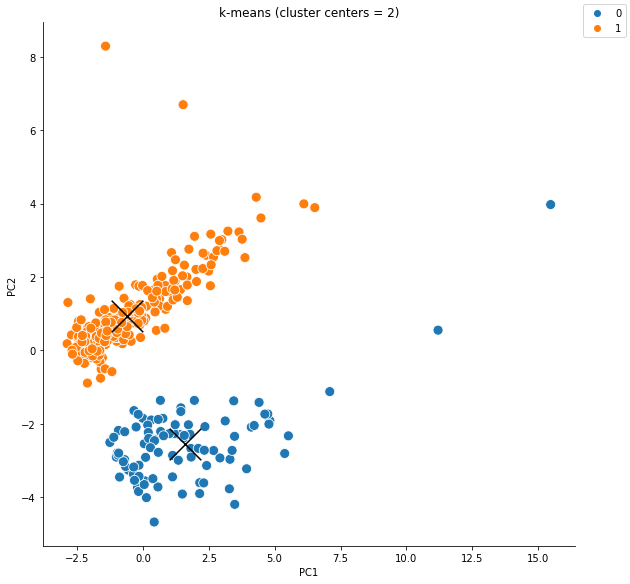

In [112]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')

In [99]:
kmeans.cluster_centers_

array([[ 1.58300741, -2.5347103 ],
       [-0.59038391,  0.94532228]])

In [86]:
for i in range(3):
    secondaryDf['p' + str(i)] = 0
    
secondaryDf[['p0', 'p1']] = soft_clustering_weights(secondaryDf[['PC1','PC2']].to_numpy(), kmeans.cluster_centers_)

In [88]:
secondaryDf['confidence'] = np.max(secondaryDf[['p0', 'p1']].values, axis = 1)

In [90]:
secondaryDf['y']=y

In [91]:
df_color_converter = secondaryDf.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']

KeyError: 'Column not found: labels'